<a href="https://colab.research.google.com/github/cthmayo/line-placement/blob/main/Line_Position.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This project was an attempt at the [RANZCR CLiP - Catheter and Line Position Challenge](https://www.kaggle.com/c/ranzcr-clip-catheter-line-classification/). 

# Imports

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
from zipfile import ZipFile
from io import StringIO
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
np.random.seed(42)
import tensorflow as tf
from tensorflow import keras

In [ ]:
z = ZipFile('/content/drive/My Drive/Line Placement Project/train.csv.zip')
z.extractall()

In [ ]:
z = ZipFile('/content/drive/My Drive/Line Placement Project/train_annotations.csv.zip')
z.extractall()

In [ ]:
# this takes around 10 minutes to extract
z = ZipFile('/content/drive/My Drive/Line Placement Project/train.zip')
z.extractall()

In [ ]:
all_data = pd.read_csv('train.csv')
annotations = pd.read_csv('train_annotations.csv')

# EDA and Visualisations

In [ ]:
all_data.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30083 entries, 0 to 30082
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   StudyInstanceUID            30083 non-null  object
 1   ETT - Abnormal              30083 non-null  int64 
 2   ETT - Borderline            30083 non-null  int64 
 3   ETT - Normal                30083 non-null  int64 
 4   NGT - Abnormal              30083 non-null  int64 
 5   NGT - Borderline            30083 non-null  int64 
 6   NGT - Incompletely Imaged   30083 non-null  int64 
 7   NGT - Normal                30083 non-null  int64 
 8   CVC - Abnormal              30083 non-null  int64 
 9   CVC - Borderline            30083 non-null  int64 
 10  CVC - Normal                30083 non-null  int64 
 11  Swan Ganz Catheter Present  30083 non-null  int64 
 12  PatientID                   30083 non-null  object
dtypes: int64(11), object(2)
memory usage: 3.0+ MB


In [ ]:
for column in all_data.columns:
  print(all_data[column].value_counts())
  print('...')

1.2.826.0.1.3680043.8.498.11958092588105301829462308733655599561    1
1.2.826.0.1.3680043.8.498.81956787033106982083732322130554035422    1
1.2.826.0.1.3680043.8.498.45667033584171921001890022815707001978    1
1.2.826.0.1.3680043.8.498.30259802951547165453232713614309788451    1
1.2.826.0.1.3680043.8.498.76367705763350679415714976079565694494    1
                                                                   ..
1.2.826.0.1.3680043.8.498.44145003801254514585942791621044424427    1
1.2.826.0.1.3680043.8.498.45625024148828202987060942852277344871    1
1.2.826.0.1.3680043.8.498.92133005833092487864867568030034389273    1
1.2.826.0.1.3680043.8.498.15874263843993478537449521213940734912    1
1.2.826.0.1.3680043.8.498.86498704670352546021872638306143758459    1
Name: StudyInstanceUID, Length: 30083, dtype: int64
...
0    30004
1       79
Name: ETT - Abnormal, dtype: int64
...
0    28945
1     1138
Name: ETT - Borderline, dtype: int64
...
0    22843
1     7240
Name: ETT - Normal, dtype: i

All classes are clearly very unbalanced.

Also checking annotations...

In [ ]:
annotations[annotations['StudyInstanceUID'] == '1.2.826.0.1.3680043.8.498.67333715852583257644524224536914010588']

,StudyInstanceUID,label,data
9999,1.2.826.0.1.3680043.8.498.67333715852583257644...,CVC - Normal,"[[1021, 903], [1069, 793], [1138, 694], [1250,..."
10000,1.2.826.0.1.3680043.8.498.67333715852583257644...,CVC - Normal,"[[1064, 904], [1094, 821], [1117, 733], [1122,..."
10001,1.2.826.0.1.3680043.8.498.67333715852583257644...,NGT - Borderline,"[[1477, 1951], [1501, 1913], [1521, 1801], [14..."


In [ ]:
eval(annotations['data'].values[0])

[[1487, 1279],
 [1477, 1168],
 [1472, 1052],
 [1464, 924],
 [1453, 827],
 [1443, 755],
 [1434, 640],
 [1404, 514],
 [1387, 497],
 [1360, 541],
 [1290, 617],
 [1228, 696],
 [1179, 776],
 [1116, 880],
 [1065, 963],
 [1031, 999]]

In [ ]:
def show_image(image_name, annotations_on=False):
  fig, ax = plt.subplots()
  plt.imshow(mpimg.imread(image_name+'.jpg'))
  # allow annotations to be shown on the imge
  if annotations_on:
    relevant_annotations = annotations[annotations['StudyInstanceUID'] == image_name]
    for label, points in zip(relevant_annotations['label'],relevant_annotations['data']):
      plt.scatter(*np.transpose(np.asarray(eval(points))),label=label)
    ax.legend()

In [ ]:
def get_image(image_name):
  return mpimg.imread(image_name+'.jpg')

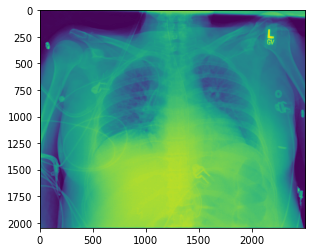

In [ ]:
show_image('1.2.826.0.1.3680043.8.498.67333715852583257644524224536914010588')

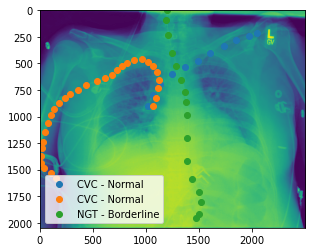

In [ ]:
show_image('1.2.826.0.1.3680043.8.498.67333715852583257644524224536914010588',annotations_on=True)

# Split test and train

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_set, test_set = train_test_split(all_data, test_size = 0.1, random_state = 42)

In [ ]:
X_train = train_set['StudyInstanceUID'].values
y_train = train_set[['ETT - Abnormal', 'ETT - Borderline',
       'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
       'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
       'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present']].values
X_test = test_set['StudyInstanceUID'].values
y_test = test_set[['ETT - Abnormal', 'ETT - Borderline',
       'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
       'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
       'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present']].values

# Metric

The metric in this competition is the mean columnwise AUROC.

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
def evaluate_predictions(y_true, y_score):
  aurocs = []
  for i in range(y_true.shape[1]):
    aurocs.append(roc_auc_score(y_true[:,i],y_score[:,1]))
  return np.mean(aurocs)

Test the metric on a dummy entry.

In [ ]:
y_pred = np.zeros(y_test.shape)

In [ ]:
evaluate_predictions(y_test, y_pred)

0.5

# Preprocessing

At this preprocessing stage, I will convert the images to 224x224

In [ ]:
test_image = get_image('1.2.826.0.1.3680043.8.498.50081834838807662914946486486940697786')
test_image.shape

(2048, 2500)

In [ ]:
test_image_resized = cv.resize(test_image,(224,224))
test_image_resized.shape

(224, 224)

In [ ]:
def get_and_resize_all_images(X):
  all_img = []
  for image_name in tqdm_notebook(X):
    img = get_image(image_name)
    all_img.append(cv.resize(img,(224,224)))
  return np.asarray(all_img)

In [ ]:
X_train_images = get_and_resize_all_images(X_train)

In [ ]:
X_test_images = get_and_resize_all_images(X_test)

# Random Forests on pixel values

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X_train_images_flat = X_train_images.reshape((X_train_images.shape[0], X_train_images.shape[1] * X_train_images.shape[2]))

In [ ]:
trees = []
for i in tqdm_notebook(range(y_train.shape[1])):
  new_tree_clf = RandomForestClassifier(max_depth=6)
  new_tree_clf.fit(X_train_images_flat,y_train[:,i])
  trees.append(new_tree_clf)

In [ ]:
X_test_images_flat = X_test_images.reshape((X_test_images.shape[0], X_test_images.shape[1] * X_test_images.shape[2]))

In [ ]:
trees[0].predict(X_test_images_flat)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
prediction_list = []
for tree in trees:
  prediction_list.append(tree.predict_proba(X_test_images_flat)[:,1])

In [ ]:
y_pred = np.transpose(np.asarray(prediction_list))

In [ ]:
evaluate_predictions(y_test, y_pred)

0.7046465770468845

# CNNs

## Create a validation set

In [ ]:
X_train_smaller, X_val, y_train_smaller, y_val = train_test_split(X_train_images,y_train,test_size=0.1,random_state=43)

In [ ]:
def three_channel_images(X):
  X2 = X.reshape(X.shape + (1,))
  return np.concatenate([X2,X2,X2],axis=3)

In [ ]:
X_train_smaller = three_channel_images(X_train_smaller)
X_val = three_channel_images(X_val)
X_test_images_three_channel = three_channel_images(X_test_images)

In [ ]:
X_train_smaller.shape, y_train_smaller.shape

((24366, 224, 224, 3), (24366, 11))

## Compile and train function

In [ ]:
def compile_and_train_cnn(model):
  model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Nadam(learning_rate=1e-05),
              metrics=[keras.metrics.AUC(multi_label=True,name='averaged_auc')])
  early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_averaged_auc',patience=4,restore_best_weights=True,mode='max')
  history = model.fit(X_train_smaller,y_train_smaller,epochs=3000,validation_data=(X_val,y_val),callbacks=[early_stopping_cb])

## DenseNet169

In [ ]:
densenet = keras.models.Sequential([
                                   keras.layers.Input(shape=(224,224,3)),
                                   keras.layers.Lambda(lambda x: keras.applications.densenet.preprocess_input(x)),
                                   keras.applications.DenseNet169(include_top=False,pooling='avg'),
                                   keras.layers.Dense(11, activation='sigmoid')
])

In [ ]:
compile_and_train_cnn(densenet)

Epoch 1/3000
762/762 [==============================] - 264s 281ms/step - loss: 0.5306 - averaged_auc: 0.5975 - val_loss: 0.2609 - val_averaged_auc: 0.7593
Epoch 2/3000
762/762 [==============================] - 209s 275ms/step - loss: 0.2456 - averaged_auc: 0.7786 - val_loss: 0.2262 - val_averaged_auc: 0.8145
Epoch 3/3000
762/762 [==============================] - 207s 271ms/step - loss: 0.2140 - averaged_auc: 0.8402 - val_loss: 0.2132 - val_averaged_auc: 0.8198
Epoch 4/3000
762/762 [==============================] - 207s 271ms/step - loss: 0.1948 - averaged_auc: 0.8863 - val_loss: 0.2098 - val_averaged_auc: 0.8336
Epoch 5/3000
762/762 [==============================] - 207s 272ms/step - loss: 0.1719 - averaged_auc: 0.9160 - val_loss: 0.2113 - val_averaged_auc: 0.8436
Epoch 6/3000
762/762 [==============================] - 206s 270ms/step - loss: 0.1447 - averaged_auc: 0.9433 - val_loss: 0.2153 - val_averaged_auc: 0.8389
Epoch 7/3000
762/762 [==============================] - 207s 271

In [ ]:
y_pred = densenet.predict(X_test_images_three_channel)

In [ ]:
evaluate_predictions(y_test, y_pred)

0.7727301097905159

In [ ]:
densenet.save_weights('/content/drive/My Drive/Line Placement Project/densenet169.h5')

## Inception v3

Note: Inception v3 can take images of up to (299,299,3)

In [ ]:
inceptionv3 = keras.models.Sequential([
                                   keras.layers.Input(shape=(224,224,3)),
                                   keras.layers.Lambda(lambda x: tf.keras.applications.inception_v3.preprocess_input(x)),
                                   keras.applications.InceptionV3(include_top=False,pooling='avg'),
                                   keras.layers.Dense(11, activation='sigmoid')
])

87916544/87910968 [==============================] - 2s 0us/step


In [ ]:
compile_and_train_cnn(inceptionv3)

Epoch 1/3000
762/762 [==============================] - 151s 173ms/step - loss: 0.4206 - averaged_auc: 0.6025 - val_loss: 0.2568 - val_averaged_auc: 0.7455
Epoch 2/3000
762/762 [==============================] - 129s 170ms/step - loss: 0.2509 - averaged_auc: 0.7790 - val_loss: 0.2386 - val_averaged_auc: 0.7793
Epoch 3/3000
762/762 [==============================] - 129s 170ms/step - loss: 0.2225 - averaged_auc: 0.8310 - val_loss: 0.2292 - val_averaged_auc: 0.7858
Epoch 4/3000
762/762 [==============================] - 129s 169ms/step - loss: 0.2009 - averaged_auc: 0.8767 - val_loss: 0.2295 - val_averaged_auc: 0.7924
Epoch 5/3000
762/762 [==============================] - 128s 168ms/step - loss: 0.1758 - averaged_auc: 0.9124 - val_loss: 0.2366 - val_averaged_auc: 0.7873
Epoch 6/3000
762/762 [==============================] - 128s 168ms/step - loss: 0.1421 - averaged_auc: 0.9430 - val_loss: 0.2578 - val_averaged_auc: 0.7826
Epoch 7/3000
762/762 [==============================] - 128s 168

In [ ]:
y_pred = inceptionv3.predict(X_test_images_three_channel)

In [ ]:
evaluate_predictions(y_test, y_pred)

0.7781035306025746

In [ ]:
inceptionv3.save_weights('/content/drive/My Drive/Line Placement Project/inceptionv3.h5')

## EfficientNetB0

In [ ]:
efficientnetb0 = keras.models.Sequential([
                                   keras.layers.Input(shape=(224,224,3)),
                                   keras.applications.EfficientNetB0(include_top=False,pooling='avg'),
                                   keras.layers.Dense(11, activation='sigmoid')
])

In [ ]:
compile_and_train_cnn(efficientnetb0)

Epoch 1/3000
762/762 [==============================] - 272s 324ms/step - loss: 0.5116 - averaged_auc: 0.5497 - val_loss: 0.2774 - val_averaged_auc: 0.7059
Epoch 2/3000
762/762 [==============================] - 245s 322ms/step - loss: 0.2735 - averaged_auc: 0.7199 - val_loss: 0.2556 - val_averaged_auc: 0.7423
Epoch 3/3000
762/762 [==============================] - 246s 322ms/step - loss: 0.2566 - averaged_auc: 0.7521 - val_loss: 0.2478 - val_averaged_auc: 0.7658
Epoch 4/3000
762/762 [==============================] - 246s 322ms/step - loss: 0.2489 - averaged_auc: 0.7733 - val_loss: 0.2412 - val_averaged_auc: 0.7767
Epoch 5/3000
762/762 [==============================] - 245s 322ms/step - loss: 0.2374 - averaged_auc: 0.7957 - val_loss: 0.2340 - val_averaged_auc: 0.7848
Epoch 6/3000
762/762 [==============================] - 246s 323ms/step - loss: 0.2339 - averaged_auc: 0.8109 - val_loss: 0.2287 - val_averaged_auc: 0.7872
Epoch 7/3000
762/762 [==============================] - 246s 322

In [ ]:
y_pred = efficientnetb0.predict(X_test_images_three_channel)

In [ ]:
evaluate_predictions(y_test, y_pred)

0.7816039389601308

In [ ]:
efficientnetb0.save_weights('/content/drive/My Drive/Line Placement Project/efficientnetb0.h5')

## Data augmentation

In [ ]:
translation_layer = keras.layers.experimental.preprocessing.RandomTranslation(0.1,0.1,fill_mode='nearest')
rotation_layer = keras.layers.experimental.preprocessing.RandomRotation(0.05,fill_mode='nearest')
zoom_layer = keras.layers.experimental.preprocessing.RandomZoom((-0.2,0.2),fill_mode='nearest')

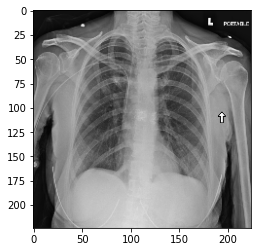

In [ ]:
plt.imshow(X_train_smaller[0])

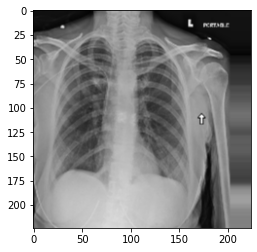

In [ ]:
plt.imshow(translation_layer(np.asarray([X_train_smaller[0]]))[0])

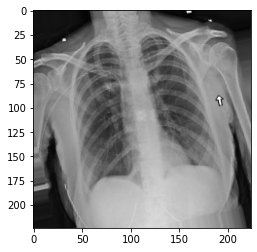

In [ ]:
plt.imshow(rotation_layer(np.asarray([X_train_smaller[0]]))[0])

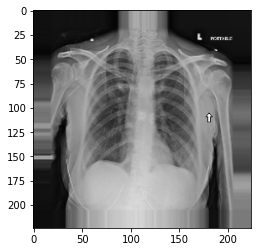

In [ ]:
plt.imshow(zoom_layer(np.asarray([X_train_smaller[0]]))[0])

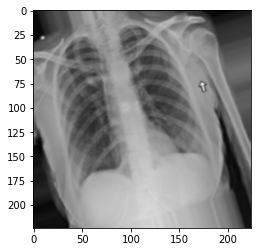

In [ ]:
plt.imshow(zoom_layer(rotation_layer(translation_layer(np.asarray([X_train_smaller[0]]))))[0])

## EfficientNetB0 with augmentation layers

In [ ]:
efficientnetb0 = keras.models.Sequential([
                                   keras.layers.Input(shape=(224,224,3)),
                                   keras.layers.experimental.preprocessing.RandomTranslation(0.1,0.1,fill_mode='nearest'),
                                   keras.layers.experimental.preprocessing.RandomRotation(0.05,fill_mode='nearest'),
                                   keras.layers.experimental.preprocessing.RandomZoom((-0.2,0.2),fill_mode='nearest'),
                                   keras.applications.EfficientNetB0(include_top=False,pooling='avg'),
                                   keras.layers.Dense(11, activation='sigmoid')
])

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
#compile_and_train_cnn(efficientnetb0)

Epoch 1/3000
762/762 [==============================] - 278s 333ms/step - loss: 0.5571 - averaged_auc: 0.5460 - val_loss: 0.2868 - val_averaged_auc: 0.6715
Epoch 2/3000
762/762 [==============================] - 251s 330ms/step - loss: 0.2811 - averaged_auc: 0.7028 - val_loss: 0.2731 - val_averaged_auc: 0.7022
Epoch 3/3000
762/762 [==============================] - 252s 330ms/step - loss: 0.2635 - averaged_auc: 0.7281 - val_loss: 0.2699 - val_averaged_auc: 0.7267
Epoch 4/3000
762/762 [==============================] - 251s 330ms/step - loss: 0.2569 - averaged_auc: 0.7488 - val_loss: 0.2681 - val_averaged_auc: 0.7420
Epoch 5/3000
762/762 [==============================] - 251s 330ms/step - loss: 0.2517 - averaged_auc: 0.7639 - val_loss: 0.2629 - val_averaged_auc: 0.7564
Epoch 6/3000
762/762 [==============================] - 251s 330ms/step - loss: 0.2454 - averaged_auc: 0.7697 - val_loss: 0.2556 - val_averaged_auc: 0.7652
Epoch 7/3000
762/762 [==============================] - 251s 330

Model saving stuff (for Kaggle)

In [ ]:
efficientnetb0 = keras.models.Sequential([
                                   keras.layers.Input(shape=(224,224,3)),
                                   keras.applications.EfficientNetB0(include_top=False,pooling='avg'),
                                   keras.layers.Dense(11, activation='sigmoid')
])

In [ ]:
efficientnetb0.load_weights('/content/drive/My Drive/Line Placement Project/efficientnetb0_2.h5')

In [ ]:
y_pred = efficientnetb0.predict(X_test_images_three_channel)

In [ ]:
evaluate_predictions(y_test, y_pred)

0.7779287933588376

In [ ]:
efficientnetb0.save('/content/drive/My Drive/Line Placement Project/efficientnetb0_2')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Line Placement Project/efficientnetb0_2/assets


In [ ]:
efficientnetb0.save_weights('/content/drive/My Drive/Line Placement Project/efficientnetb0_2.h5')